### Load Model

In [1]:
import lightning as L
import torch
from tools import PyTorchMLP, LightningModel, MNISTDataModule

In [2]:
pt_model = PyTorchMLP(num_features=784, num_classes=10)

lt_model = LightningModel.load_from_checkpoint(
    checkpoint_path="lt_model.ckpt", model=pt_model
)

In [3]:
d_module = MNISTDataModule()
d_module.setup(stage="test")

### Use new data for prediction

In [4]:
import torchmetrics

test_dataloader = d_module.test_dataloader()
acc = torchmetrics.Accuracy(task="multiclass", num_classes=10)

In [5]:
for batch in test_dataloader:

    features, true_labels = batch

    with torch.inference_mode():
        logits = lt_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    acc(predicted_labels, true_labels)

predicted_labels[:5]

tensor([1, 2, 3, 4, 5])

In [6]:
test_acc = acc.compute()
print(f"test accuracy: {test_acc * 100:.2f}%")

test accuracy: 96.53%


### Analysing failure cases

In [7]:
!pip install mlxtend

In [8]:
class_dict = {0: 'digit 0',
              1: 'digit 1',
              2: 'digit 2',
              3: 'digit 3',
              4: 'digit 4',
              5: 'digit 5',
              6: 'digit 6',
              7: 'digit 7',
              8: 'digit 8',
              9: 'digit 9'}

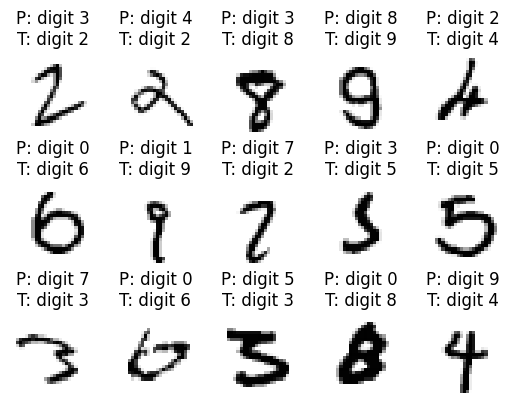

In [9]:
import matplotlib.pyplot as plt
from plotting_utils import show_failures

show_failures(
    model=lt_model, data_loader=test_dataloader, class_dict=class_dict
)

plt.savefig('failures.pdf')

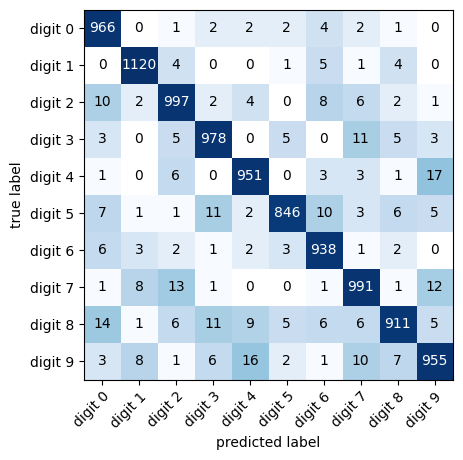

In [10]:
import matplotlib

from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import ConfusionMatrix

cmat = ConfusionMatrix(task="multiclass", num_classes=len(class_dict))

for x, y in d_module.test_dataloader():

    with torch.inference_mode():
        pred = lt_model(x)
    cmat(pred, y)

cmat_tensor = cmat.compute()
cmat = cmat_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=cmat,
    class_names=class_dict.values(),
    norm_colormap=matplotlib.colors.LogNorm()
)
plt.xticks(rotation=45, ha="right", rotation_mode="anchor")
plt.show()